In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Generate 100 houses
n_samples = 100

# Generate features
square_feet = np.random.uniform(1000, 4000, n_samples)
bedrooms = np.random.randint(1, 6, n_samples)
bathrooms = np.random.randint(1, 4, n_samples)
age = np.random.uniform(0, 50, n_samples)
garden_size = np.random.uniform(0, 1000, n_samples)
distance_to_city = np.random.uniform(0, 30, n_samples)

# Create price with some features being more important
price = (
    200000 +                          # Base price
    (150 * square_feet) +            # Important
    (25000 * bedrooms) +             # Important
    (35000 * bathrooms) +            # Important
    (-100 * age) +                   # Less important
    (50 * garden_size) +             # Important
    (-500 * distance_to_city) +      # Less important
    np.random.normal(0, 50000, n_samples)  # Random noise
)

# Create DataFrame
house_data = pd.DataFrame({
    'square_feet': square_feet,
    'bedrooms': bedrooms,
    'bathrooms': bathrooms,
    'age': age,
    'garden_size': garden_size,
    'distance_to_city': distance_to_city,
    'price': price
})

print("First 5 rows of our dataset:")
print(house_data.head())

First 5 rows of our dataset:
   square_feet  bedrooms  bathrooms        age  garden_size  distance_to_city  \
0  2123.620357         1          1  27.840063   642.419278         14.778753   
1  3852.142919         4          1  46.807739    26.511311          0.340609   
2  3195.981825         5          2  34.801490   585.775581         14.059819   
3  2795.975453         4          3  28.503059   940.230241          1.689098   
4  1468.055921         5          3   4.858825   575.474178          3.564537   

           price  
0  549471.472152  
1  895841.202973  
2  967628.252960  
3  911604.233398  
4  655031.429541  


In [3]:
# Separate features (X) and target (y)
X = house_data.drop('price', axis=1)  # All columns except price
y = house_data['price']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale the features (important for Lasso!)
scaler = StandardScaler()

# Adjust data to have the same scale 
# i.e. Square feet (1000-4000) and bedrooms (1-5) are on very different scales
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Show what scaling does to the data
print("Before scaling (first 3 rows, first 3 features):")
print(X_train.iloc[0:3, 0:3])
print("\nAfter scaling (first 3 rows, first 3 features):")
print(X_train_scaled[0:3, 0:3])

Before scaling (first 3 rows, first 3 features):
    square_feet  bedrooms  bathrooms
55  3765.622705         1          3
88  3661.638228         3          2
26  1599.021346         1          3

After scaling (first 3 rows, first 3 features):
[[ 1.55811593 -1.3805137   1.42366426]
 [ 1.43909981  0.05378625  0.18569534]
 [-0.92168212 -1.3805137   1.42366426]]


In [4]:
# Initialize and train Lasso model
# alpha is the strength of the penalty (higher = more features might be eliminated)
lasso = Lasso(alpha=10)  
lasso.fit(X_train_scaled, y_train)

# Print feature importance
# Coefficients are the weights of the features e.g. square feet, bedrooms, etc.
# Its the amount each feature contributes to the prediction of the target variable
# e.g. a coefficient of 100 for square feet means that every 1 square foot contributes 100 to the prediction of the target variable
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lasso.coef_
})
# Sort by absolute value of coefficient
feature_importance['Abs_Coefficient'] = abs(feature_importance['Coefficient'])
feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)

print("Feature Importance:")
print(feature_importance)

# Print R² score, 1 is a perfect fit, 0 is no fit
train_score = lasso.score(X_train_scaled, y_train)
test_score = lasso.score(X_test_scaled, y_test)
print(f'\nR² score (training): {train_score:.3f}')
print(f'R² score (testing): {test_score:.3f}')

Feature Importance:
            Feature    Coefficient  Abs_Coefficient
0       square_feet  132182.246279    132182.246279
1          bedrooms   39875.647923     39875.647923
2         bathrooms   22790.092529     22790.092529
4       garden_size   19622.505838     19622.505838
5  distance_to_city  -13035.026975     13035.026975
3               age   -4898.493423      4898.493423

R² score (training): 0.907
R² score (testing): 0.873


In [5]:
# Make predictions
y_pred_train = lasso.predict(X_train_scaled)
y_pred_test = lasso.predict(X_test_scaled)

# Create comparison DataFrame for test data
comparison_df = pd.DataFrame({
    'Actual Price': y_test,
    'Predicted Price': y_pred_test,
    'Difference': y_test - y_pred_test
})

# Add percentage error
comparison_df['Percent Error'] = (abs(comparison_df['Difference']) / comparison_df['Actual Price']) * 100

print("First 5 predictions vs actual values:")
print(comparison_df.head())
print(f"\nAverage percent error: {comparison_df['Percent Error'].mean():.2f}%")

First 5 predictions vs actual values:
     Actual Price  Predicted Price    Difference  Percent Error
83  519301.873311    574841.227119 -55539.353808      10.695004
53  800111.974028    879470.755202 -79358.781173       9.918459
70  930177.844946    909927.181749  20250.663196       2.177074
45  746542.200958    778654.825654 -32112.624696       4.301515
44  591525.950162    536325.039458  55200.910705       9.331951

Average percent error: 6.67%


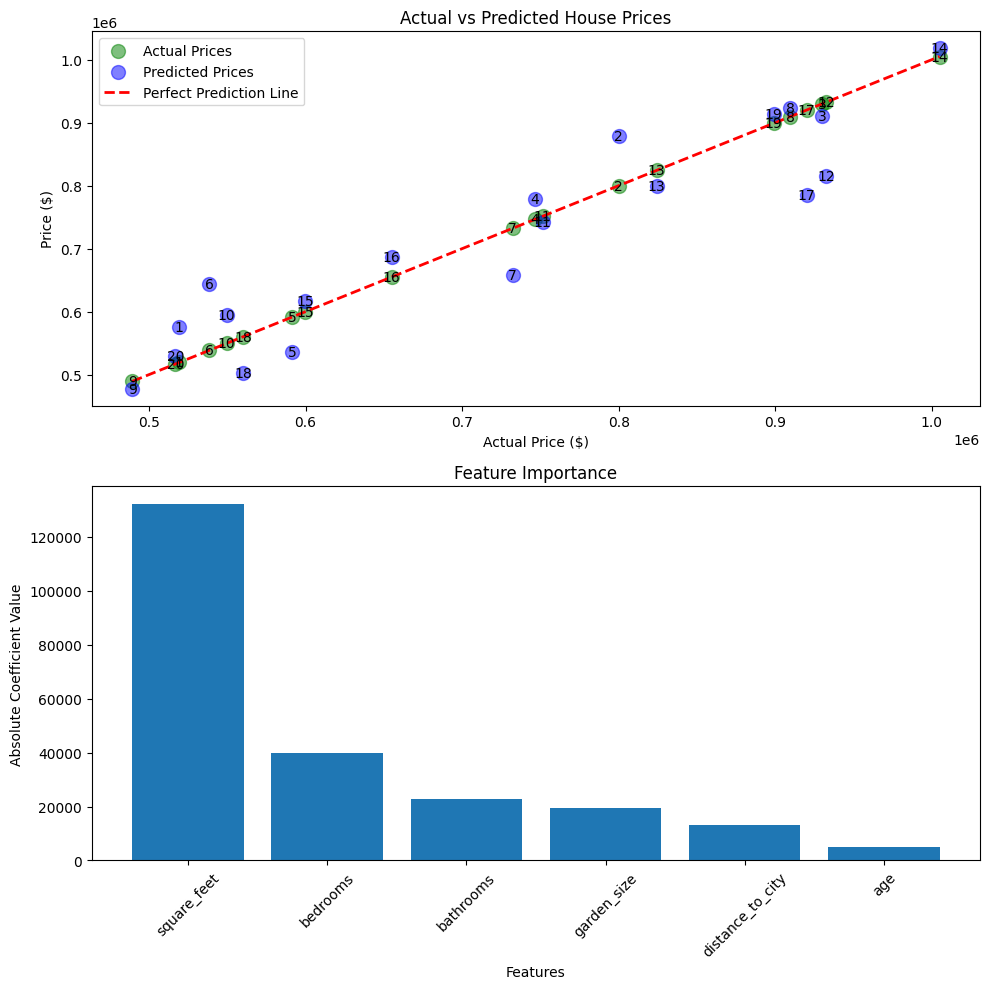

In [6]:
# Create figure 
plt.figure(figsize=(10, 10))

# First plot: Actual vs Predicted with numbered pairs
plt.subplot(2, 1, 1)  # First subplot

# Convert to numpy arrays
y_test_array = y_test.values
y_pred_test_array = y_pred_test

# Plot each pair with a number
for i in range(len(y_test_array)):
    # Plot actual price (green) with number
    plt.scatter(y_test_array[i], y_test_array[i], 
               color='green', alpha=0.5,
               s=100, label='Actual Prices' if i == 0 else "")
    plt.annotate(f'{i+1}', 
                (y_test_array[i], y_test_array[i]), 
                xytext=(0, 0),
                textcoords='offset points',
                ha='center',
                va='center')
    
    # Plot predicted price (blue) with same number
    plt.scatter(y_test_array[i], y_pred_test_array[i], 
               color='blue', alpha=0.5,
               s=100, label='Predicted Prices' if i == 0 else "")
    plt.annotate(f'{i+1}', 
                (y_test_array[i], y_pred_test_array[i]), 
                xytext=(0, 0),
                textcoords='offset points',
                ha='center',
                va='center')

# Add perfect prediction line
plt.plot([y_test_array.min(), y_test_array.max()], 
         [y_test_array.min(), y_test_array.max()], 
         'r--', lw=2, label='Perfect Prediction Line')

plt.xlabel('Actual Price ($)')
plt.ylabel('Price ($)')
plt.title('Actual vs Predicted House Prices')
plt.legend()

# Second plot: Feature Importance
plt.subplot(2, 1, 2)  # Second subplot
plt.bar(range(len(feature_importance)), feature_importance['Abs_Coefficient'])
plt.xticks(range(len(feature_importance)), feature_importance['Feature'], rotation=45)
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Absolute Coefficient Value')

plt.tight_layout()
plt.show()